# Primer Punto

Entrenar una máquina de vectores de soporte (SVM) sobre la base de datos Website Phishing balanceada y realizar validación cruzada para determinar el desempeño del clasificador. Se deberán probar diferentes kernels y parámetros del kernel.

## Objetivos
- Entrenar una máquina de vectores de soporte (SVM) sobre el dataset Website Phishing balanceado
- Realizar validación cruzada para determinar el desempeño del clasificador
- Probar diferentes kernels (lineal, RBF, polinomial, sigmoide)
- Optimizar hiperparámetros usando GridSearchCV
- Comparar rendimiento entre diferentes configuraciones

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 1. Carga y Exploración del Dataset

El dataset utilizado es el [Website Phishing](https://archive.ics.uci.edu/dataset/379/website+phishing) de UCI Machine Learning Repository, previamente balanceado en el notebook 00_point.ipynb.

In [ ]:
# Cargar el dataset Website Phishing balanceado
try:
    data = pd.read_csv("phishing_balanced.csv")
    print("Dataset Website Phishing balanceado cargado exitosamente")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'phishing_balanced.csv'")
    print(
        "Ejecute primero el notebook 00_point.ipynb para generar el dataset balanceado"
    )
    # Como alternativa, cargar el dataset original y balancearlo aquí
    print("\nCargando dataset original como alternativa...")
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00379/PhishingData.arff"
    response = requests.get(url)
    from scipy.io import arff

    data_arff = arff.loadarff(io.StringIO(response.text.decode("utf-8")))
    data = pd.DataFrame(data_arff[0])

    # Balancear el dataset aquí si es necesario
    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import LabelEncoder

    target_column = data.columns[-1]
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Codificar variables categóricas
    # IMPORTANTE: Usar LabelEncoder separado para la variable objetivo
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    X_encoded = X.copy()
    le_features = {}  # Diccionario para almacenar encoders de cada columna

    for col in X_encoded.columns:
        if X_encoded[col].dtype == "object":
            le_features[col] = LabelEncoder()
            X_encoded[col] = le_features[col].fit_transform(X_encoded[col])

    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_encoded, y_encoded)

    # Reconstruir DataFrame
    data = pd.DataFrame(X_balanced, columns=X_encoded.columns)
    data[target_column] = le_target.inverse_transform(y_balanced)
    print("Dataset balanceado con SMOTE")

# Mostrar información básica del dataset
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas del dataset:")
print(data.head())
print("\nInformación del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())

Dataset Website Phishing balanceado cargado exitosamente
Dimensiones del dataset: (2106, 10)

Primeras filas del dataset:
   SFH  popUpWidnow  SSLfinal_State  Request_URL  URL_of_Anchor  web_traffic  \
0    2            0               2            0              0            2   
1    0            0               0            0              0            1   
2    2            0               1            1              0            1   
3    2            1               2            0              0            1   
4    0            0               2            0              1            1   

   URL_Length  age_of_domain  having_IP_Address Result  
0           2              1                  0   b'0'  
1           2              1                  1   b'1'  
2           0              1                  0   b'1'  
3           2              1                  0   b'0'  
4           0              1                  0   b'1'  

Información del dataset:
<class 'pandas.core.frame.Dat

Valores faltantes por columna:
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64


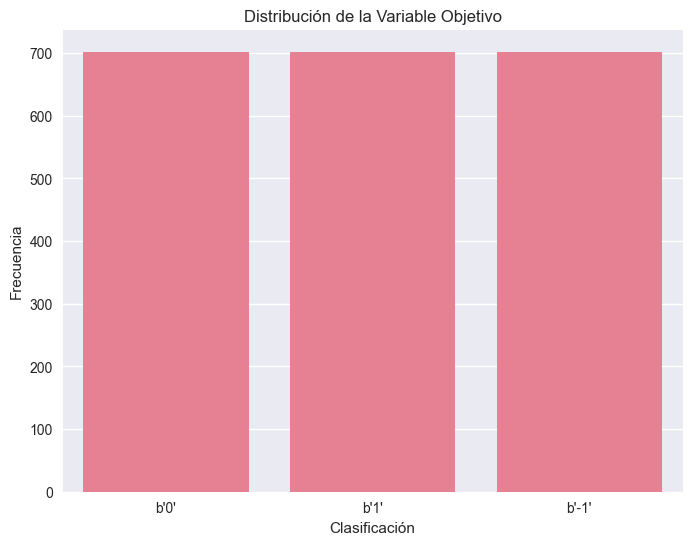

In [22]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
print(data.isnull().sum())

# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="Result")
plt.title("Distribución de la Variable Objetivo")
plt.xlabel("Clasificación")
plt.ylabel("Frecuencia")
plt.show()

## 2. Preprocesamiento de Datos

In [26]:
# Separar características y variable objetivo
target_column = data.columns[-1]  # Última columna es la variable objetivo
X = data.drop(target_column, axis=1)
y = data[target_column]

# Codificar la variable objetivo (si es necesario)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Características escaladas - Forma:", X_scaled.shape)
print("Variable objetivo codificada - Clases:", le.classes_)
print("Nombre de la variable objetivo:", target_column)

Características escaladas - Forma: (2106, 9)
Variable objetivo codificada - Clases: ["b'-1'" "b'0'" "b'1'"]
Nombre de la variable objetivo: Result


## 3. Entrenamiento de SVM con Diferentes Kernels

Se probarán los siguientes kernels:
- Lineal
- RBF (Radial Basis Function)
- Polinomial
- Sigmoide

In [25]:
# Definir los kernels a probar
kernels = ["linear", "rbf", "poly", "sigmoid"]
kernel_names = ["Lineal", "RBF", "Polinomial", "Sigmoide"]

# Diccionario para almacenar resultados
results = {}

# Entrenar SVM con cada kernel usando validación cruzada
for kernel, name in zip(kernels, kernel_names):
    print(f"\nEntrenando SVM con kernel {name}...")

    # Crear el modelo SVM
    if kernel == "poly":
        svm_model = SVC(kernel=kernel, degree=3, random_state=42)
    else:
        svm_model = SVC(kernel=kernel, random_state=42)

    # Validación cruzada
    cv_scores = cross_val_score(
        svm_model, X_scaled, y_encoded, cv=5, scoring="accuracy"
    )

    # Almacenar resultados
    results[kernel] = {
        "name": name,
        "mean_accuracy": cv_scores.mean(),
        "std_accuracy": cv_scores.std(),
        "cv_scores": cv_scores,
    }

    print(f"Precisión media: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Puntuaciones de CV: {cv_scores}")


Entrenando SVM con kernel Lineal...
Precisión media: 0.7963 (+/- 0.0372)
Puntuaciones de CV: [0.76303318 0.81947743 0.79572447 0.80522565 0.79809976]

Entrenando SVM con kernel RBF...
Precisión media: 0.9164 (+/- 0.0264)
Puntuaciones de CV: [0.89336493 0.9192399  0.91211401 0.93111639 0.9263658 ]

Entrenando SVM con kernel Polinomial...
Precisión media: 0.8865 (+/- 0.0363)
Puntuaciones de CV: [0.87440758 0.88836105 0.85985748 0.91211401 0.89786223]

Entrenando SVM con kernel Sigmoide...
Precisión media: 0.5674 (+/- 0.0386)
Puntuaciones de CV: [0.57819905 0.57957245 0.58907363 0.5368171  0.55344418]


## 4. Optimización de Hiperparámetros

Utilizaremos GridSearchCV para encontrar los mejores parámetros para cada kernel.

In [27]:
# Definir los espacios de parámetros para cada kernel
param_grids = {
    "linear": {"C": [0.1, 1, 10, 100]},
    "rbf": {"C": [0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, "scale", "auto"]},
    "poly": {
        "C": [0.1, 1, 10, 100],
        "degree": [2, 3, 4],
        "gamma": [0.001, 0.01, 0.1, 1, "scale", "auto"],
    },
    "sigmoid": {
        "C": [0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1, "scale", "auto"],
    },
}

# Diccionario para almacenar los mejores modelos
best_models = {}

# Optimización para cada kernel
for kernel in kernels:
    print(f"\nOptimizando hiperparámetros para kernel {kernel}...")

    # Crear el modelo base
    svm_model = SVC(kernel=kernel, random_state=42)

    # GridSearchCV
    grid_search = GridSearchCV(
        svm_model, param_grids[kernel], cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )

    # Entrenar el modelo
    grid_search.fit(X_scaled, y_encoded)

    # Almacenar el mejor modelo
    best_models[kernel] = {
        "model": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
    }

    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Mejor puntuación de CV: {grid_search.best_score_:.4f}")


Optimizando hiperparámetros para kernel linear...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros: {'C': 10}
Mejor puntuación de CV: 0.8011

Optimizando hiperparámetros para kernel rbf...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'C': 10, 'gamma': 0.1}
Mejor puntuación de CV: 0.9383

Optimizando hiperparámetros para kernel poly...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

## 5. Evaluación y Comparación de Modelos


Comparación de Modelos SVM:
       Kernel  Precisión CV                         Mejores Parámetros
0      Lineal      0.801058                                  {'C': 10}
1         RBF      0.938277                    {'C': 10, 'gamma': 0.1}
2  Polinomial      0.924039  {'C': 100, 'degree': 3, 'gamma': 'scale'}
3    Sigmoide      0.787777                   {'C': 10, 'gamma': 0.01}


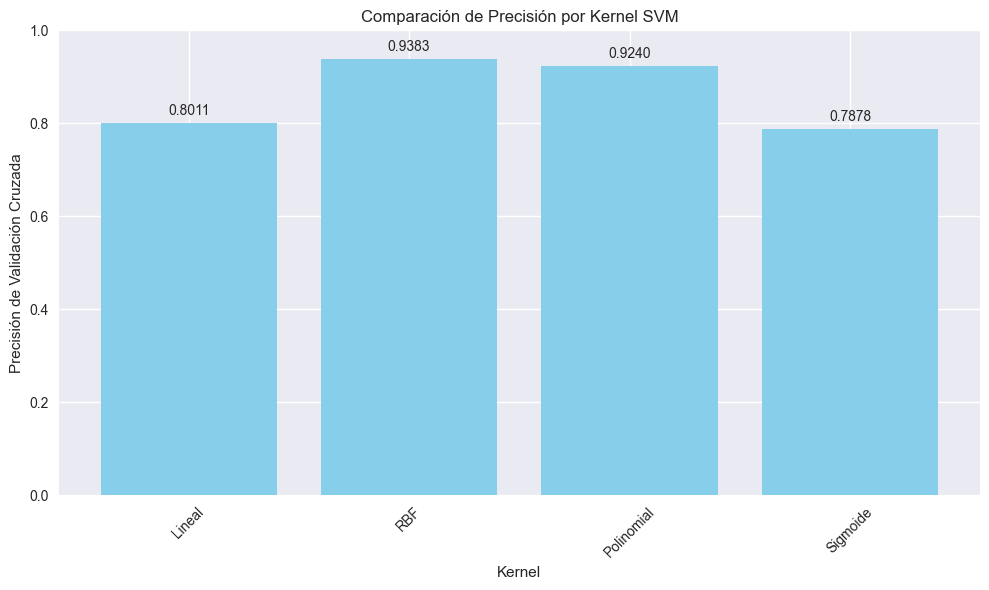

In [18]:
# Comparar los resultados de los modelos optimizados
comparison_data = []
for kernel in kernels:
    comparison_data.append({
        'Kernel': kernel_names[kernels.index(kernel)],
        'Precisión CV': best_models[kernel]['best_score'],
        'Mejores Parámetros': str(best_models[kernel]['best_params'])
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nComparación de Modelos SVM:")
print(comparison_df)

# Gráfico de comparación
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Kernel'], comparison_df['Precisión CV'], color='skyblue')
plt.title('Comparación de Precisión por Kernel SVM')
plt.xlabel('Kernel')
plt.ylabel('Precisión de Validación Cruzada')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Agregar valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Mejor modelo: Kernel RBF
Parámetros: {'C': 10, 'gamma': 0.1}
Precisión CV: 0.9383

Reporte de Clasificación:
              precision    recall  f1-score   support

       b'-1'       0.97      0.94      0.95       702
        b'0'       0.97      1.00      0.98       702
        b'1'       0.95      0.96      0.95       702

    accuracy                           0.96      2106
   macro avg       0.96      0.96      0.96      2106
weighted avg       0.96      0.96      0.96      2106



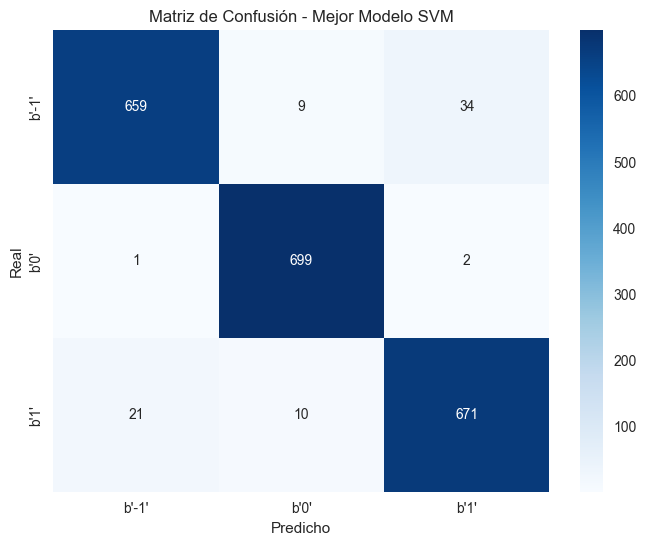

In [17]:
# Evaluación detallada del mejor modelo
best_kernel = max(best_models, key=lambda x: best_models[x]['best_score'])
best_model = best_models[best_kernel]['model']

print(f"\nMejor modelo: Kernel {best_kernel.upper()}")
print(f"Parámetros: {best_models[best_kernel]['best_params']}")
print(f"Precisión CV: {best_models[best_kernel]['best_score']:.4f}")

# Entrenar el mejor modelo en todo el conjunto de datos
best_model.fit(X_scaled, y_encoded)

# Predicciones en el conjunto de entrenamiento (para evaluación)
y_pred = best_model.predict(X_scaled)

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_encoded, y_pred, target_names=[str(cls) for cls in le.classes_]))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(cls) for cls in le.classes_], yticklabels=[str(cls) for cls in le.classes_])
plt.title('Matriz de Confusión - Mejor Modelo SVM')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()